In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import collections
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable
from PIL import Image

In [2]:
input_img_dir = './monet2photo/'

_img_list_trainA = [input_img_dir+'trainA/'+item for item in os.listdir(input_img_dir+'trainA/')]
_img_list_trainB = [input_img_dir+'trainB/'+item for item in os.listdir(input_img_dir+'trainB/')]
_img_list_testA = [input_img_dir+'testA/'+item for item in os.listdir(input_img_dir+'testA/')]
_img_list_testB = [input_img_dir+'testB/'+item for item in os.listdir(input_img_dir+'testB/')]

img_list_trainA = []
for item in tqdm(_img_list_trainA):
  tempimg = np.asarray(Image.open(item, ))
  img_list_trainA.append(tempimg)
    
    
img_list_trainB = []
for item in tqdm(_img_list_trainB):
  tempimg = np.asarray(Image.open(item, ))
  img_list_trainB.append(tempimg)
    
    
img_list_testA = []
for item in tqdm(_img_list_testA):
  tempimg = np.asarray(Image.open(item, ))
  img_list_testA.append(tempimg)

img_list_testB = []
for item in tqdm(_img_list_testB):
  tempimg = np.asarray(Image.open(item, ))
  img_list_testB.append(tempimg)    
    
    


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [3]:
trainA=np.stack(img_list_trainA)/255
trainB=np.stack(img_list_trainB)/255

testA=np.stack(img_list_testA)/255
testB=np.stack(img_list_testB)/255



#trainA=trainA.reshape(trainA.shape[0],3,256,256)
#trainB=trainB.reshape(trainB.shape[0],3,256,256)

#testA=testA.reshape(testA.shape[0],3,256,256)
#testB=testB.reshape(testB.shape[0],3,256,256)


trainA=trainA.transpose(0,3,2,1)
trainB=trainB.transpose(0,3,2,1)

testA=testA.transpose(0,3,2,1)
testB=testB.transpose(0,3,2,1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


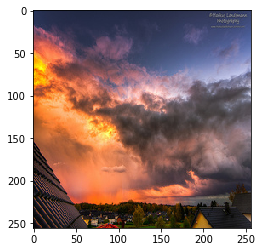

In [5]:
plt.imshow((torch.tensor(trainB[[10]]).float().to(device)).cpu().detach().numpy().transpose(0,3,2,1).squeeze(0))

In [7]:
class generator_resnet(nn.Module):
    def __init__(self
                , input_filters_down_conv7
                , output_filters_down_conv7
                , input_filters_down
                , output_filters_down
                , input_filters_res
                , output_filters_res
                , input_filters_up
                , output_filters_up
                , input_filters_up_conv7
                , output_filters_up_conv7
                , f_size=4
                ):
        super(generator_resnet, self).__init__()
        
        
        self.f_size=f_size
        self.input_filters_down_conv7=input_filters_down_conv7
        self.output_filters_down_conv7=output_filters_down_conv7
        self.input_filters_down=input_filters_down
        self.output_filters_down=output_filters_down
        self.input_filters_res=input_filters_res
        self.output_filters_res=output_filters_res
        
        self.input_filters_up=input_filters_up
        self.output_filters_up=output_filters_up
    
       
        self.input_filters_up_conv7=input_filters_up_conv7
        self.output_filters_up_conv7=output_filters_up_conv7
        
        
        self.conv7s1_down=nn.Sequential()
        self.conv7s1_up=nn.Sequential()
        self.downsample=nn.Sequential()
        self.upsample=nn.Sequential()
        
        
    
        self.dict_reflect=nn.ModuleDict()
        self.dict_conv=nn.ModuleDict()
        self.dict_norm=nn.ModuleDict()
        self.dict_relu=nn.ModuleDict()
        self.dict_reflect2=nn.ModuleDict()
        self.dict_conv2=nn.ModuleDict()
        self.dict_norm2=nn.ModuleDict()
   
    
        
        self.n_layers_conv7s1_down=len(input_filters_down_conv7)
        self.n_layers_conv7s1_up=len(input_filters_up_conv7)
        self.n_layers_res=len(input_filters_res)
        self.n_layers=len(input_filters_down)
        
        ##########  Conv7s1 DOWN   ##########
        for i in range(self.n_layers_conv7s1_down):
            
            self.conv7s1_down.add_module('Layer {} ReflectionPad'.format(i),nn.ReflectionPad2d(3))
           # self.downsample.add_module('Layer {} relu'.format(i),nn.ReLU())_filters_d
            self.conv7s1_down.add_module('Layer {} Conv2d'.format(i),nn.Conv2d(self.input_filters_down_conv7[i]
                                                     ,self.output_filters_down_conv7[i]
                                                     ,kernel_size=7
                                                     ,stride=1
                                                     ,padding=0
                                                                              ))
        
            self.conv7s1_down.add_module('Layer {} InstNorm'.format(i), nn.InstanceNorm2d(self.output_filters_down_conv7[i]))
            self.conv7s1_down.add_module('Laywer {} ReLU'.format(i), nn.ReLU())
        
        ##########  Downsample   ##########
        for i in range(self.n_layers):
            
            self.downsample.add_module('Layer {} Conv2d'.format(i),nn.Conv2d(self.input_filters_down[i]
                                                     ,self.output_filters_down[i]
                                                     ,kernel_size=3
                                                     ,stride=2
                                                     ,padding=1
                                                     ) )
            self.downsample.add_module('Layer {} InstNorm'.format(i), nn.InstanceNorm2d(self.output_filters_down[i]))
            self.downsample.add_module('Laywer {} ReLU'.format(i), nn.ReLU())
        
        ######### ResNet #########
        
        for i in range(self.n_layers_res):
            
            reflect=nn.ReflectionPad2d(1)    
            conv2d=nn.Conv2d(self.input_filters_res[i]
                                                     ,self.output_filters_res[i]
                                                     ,kernel_size=3
                                                     ,stride=1
                                                     ,padding=0
                                                     )
            
            norm=nn.InstanceNorm2d(self.output_filters_res[i])
            relu=nn.ReLU()
            self.dict_reflect['Layer {}'.format(i)]=reflect
            self.dict_conv['Layer {}'.format(i)]=conv2d
            self.dict_norm['Layer {}'.format(i)]=norm
            self.dict_relu['Layer {}'.format(i)]=relu
    
    
        
        ##########  UPsample   ##########
        for i in range(self.n_layers):
            
            self.upsample.add_module('Layer {} ConvT2d'.format(i),
                            nn.ConvTranspose2d(self.input_filters_up[i]
                                    , self.output_filters_up[i]
                                    , kernel_size = 3
                                    , stride = 2
                                    , padding = 1
                                    , output_padding=1        
                                    ))
            self.upsample.add_module('Layer {} InstNorm'.format(i), nn.InstanceNorm2d(self.output_filters_up[i]))
            self.upsample.add_module('Laywer {} ReLU'.format(i), nn.ReLU())
        
        
        
        
        
        
        ##########  Conv7s1 UP   ##########
        for i in range(self.n_layers_conv7s1_up):

        
            self.conv7s1_up.add_module('Layer {} ReflectionPad'.format(i),nn.ReflectionPad2d(3))
           # self.downsample.add_module('Layer {} relu'.format(i),nn.ReLU())_filters_d
            self.conv7s1_up.add_module('Layer {} Conv2d'.format(i),nn.Conv2d(self.input_filters_up_conv7[i]
                                                     ,self.output_filters_up_conv7[i]
                                                     ,kernel_size=7
                                                     ,stride=1
                                                     ,padding=0
                                                     ) )
            
            self.conv7s1_up.add_module('Laywer {} tanh'.format(i), nn.Tanh())
    
  
            
    def forward(self, x):
        x=self.conv7s1_down(x)
        x=self.downsample(x)
        
        for i in range(self.n_layers_res):
            shortcut = x
            reflect=self.dict_reflect['Layer {}'.format(i)]
            conv=self.dict_conv['Layer {}'.format(i)]
            norm=self.dict_norm['Layer {}'.format(i)]
            relu=self.dict_relu['Layer {}'.format(i)]

            x=reflect(x)
            x=conv(x)
            x=norm(x)
            x=relu(x)
            x=reflect(x)
            x=conv(x)
            x=norm(x)
    
            x+=shortcut
        
        
        
        x=self.upsample(x)
        x=self.conv7s1_up(x)
    
        
        return x
        

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
gener=generator_resnet(input_filters_down_conv7=[3], output_filters_down_conv7=[32]
                       ,input_filters_down=[32,64], output_filters_down=[64,128]
                       ,input_filters_res=[128,128,128,128,128,128,128,128,128], output_filters_res=[128,128,128,128,128,128,128,128,128]
                       ,input_filters_up=[128,64], output_filters_up=[64,32]
                       ,input_filters_up_conv7=[32], output_filters_up_conv7=[3])
gener=gener.to(device)

In [9]:
summary(gener,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 32, 256, 256]           4,736
    InstanceNorm2d-3         [-1, 32, 256, 256]               0
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-6         [-1, 64, 128, 128]               0
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-9          [-1, 128, 64, 64]               0
             ReLU-10          [-1, 128, 64, 64]               0
  ReflectionPad2d-11          [-1, 128, 66, 66]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
   InstanceNorm2d-13          [-1, 128, 64, 64]               0
             ReLU-14          [-1, 128,

In [10]:
class discriminator(nn.Module):
    def __init__(self
        , input_filters
        , output_filters
        , stride
        , padding
        , norm=True
        ):
        super(discriminator, self).__init__()
        
        self.input_filters=input_filters
        self.output_filters=output_filters
        self.name = 'discriminator'
        self.stride=stride
        self.padding=padding
        self.conv4 = nn.Sequential()
        
        self.n_layers=len(input_filters)
        
        
        for i in range(self.n_layers):
            
            self.conv4.add_module('Layer {} Conv2d'.format(i),
                            nn.Conv2d(self.input_filters[i]
                                    , self.output_filters[i]
                                    , kernel_size = 4
                                    , stride = self.stride[i]
                                    , padding = self.padding[i]
                                    ))
           
            self.conv4.add_module('Layer {} Instnorm'.format(i), nn.InstanceNorm2d(self.output_filters[i]))
            self.conv4.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU(0.2))
            
            if i==self.n_layers-1:
                self.conv4.add_module('Layer {} Conv2d'.format(i),
                            nn.Conv2d(self.input_filters[i]
                                    , self.output_filters[i]
                                    , kernel_size = 5
                                    , stride = self.stride[i]
                                    , padding = self.padding[i]
                                    ))


    def forward(self, x):
        x = self.conv4(x)
      
        
        return x

In [11]:
discrim=discriminator(input_filters=[3,32,64,128,256], output_filters=[32,64,128,256,1],stride=[2,2,2,2,1],padding=[1,1,1,1,2])
discrim=discrim.to(device)

In [12]:
summary(discrim,(3,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,568
    InstanceNorm2d-2         [-1, 32, 128, 128]               0
         LeakyReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          32,832
    InstanceNorm2d-5           [-1, 64, 64, 64]               0
         LeakyReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]         131,200
    InstanceNorm2d-8          [-1, 128, 32, 32]               0
         LeakyReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         524,544
   InstanceNorm2d-11          [-1, 256, 16, 16]               0
        LeakyReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13            [-1, 1, 16, 16]           6,401
   InstanceNorm2d-14            [-1, 1,

In [13]:
d_A=discriminator(input_filters=[3,32,64,128,256], output_filters=[32,64,128,256,1],stride=[2,2,2,2,1],padding=[1,1,1,1,2])
d_A=d_A.to(device)
d_B=discriminator(input_filters=[3,32,64,128,256], output_filters=[32,64,128,256,1],stride=[2,2,2,2,1],padding=[1,1,1,1,2])
d_B=d_B.to(device)

g_AB=generator_resnet(input_filters_down_conv7=[3], output_filters_down_conv7=[32]
                       ,input_filters_down=[32,64], output_filters_down=[64,128]
                       ,input_filters_res=[128,128,128,128,128,128,128,128,128], output_filters_res=[128,128,128,128,128,128,128,128,128]
                       ,input_filters_up=[128,64], output_filters_up=[64,32]
                       ,input_filters_up_conv7=[32], output_filters_up_conv7=[3])
g_AB=g_AB.to(device)

g_BA=generator_resnet(input_filters_down_conv7=[3], output_filters_down_conv7=[32]
                       ,input_filters_down=[32,64], output_filters_down=[64,128]
                       ,input_filters_res=[128,128,128,128,128,128,128,128,128], output_filters_res=[128,128,128,128,128,128,128,128,128]
                       ,input_filters_up=[128,64], output_filters_up=[64,32]
                       ,input_filters_up_conv7=[32], output_filters_up_conv7=[3])
g_BA=g_BA.to(device)

optimizer_d_A=optim.Adam(d_A.parameters(), lr=0.0002)
criterion_d_A=nn.MSELoss().to(device)

optimizer_d_B=optim.Adam(d_B.parameters(), lr=0.0002)
criterion_d_B=nn.MSELoss().to(device)

optimizer_gAB=optim.Adam(g_AB.parameters(), lr=0.0002)
criterion_gAB_1=nn.MSELoss().to(device)
criterion_gAB_2=nn.L1Loss().to(device)
criterion_gAB_3=nn.L1Loss().to(device)

optimizer_gBA=optim.Adam(g_BA.parameters(), lr=0.0002)
criterion_gBA_1=nn.MSELoss().to(device)
criterion_gBA_2=nn.L1Loss().to(device)
criterion_gBA_3=nn.L1Loss().to(device)

In [32]:
best_loss=10000
total_loss=0
be_discrim=0
be_gener=0
batch_size=1


for epoch in range(100):
    loop=0
    for a_batch, b_batch in tqdm(zip(DataLoader(trainA,batch_size,shuffle=True)
                                  ,DataLoader(trainB,batch_size,shuffle=True))):
        a_batch=a_batch.to(device=device, dtype=torch.float)
        b_batch=b_batch.to(device=device, dtype=torch.float)                             
        
        real=Variable(torch.ones(16,16)).float().to(device)            
        fake=Variable(torch.zeros(16,16)).float().to(device)            
    
        fake_B = g_AB(a_batch)
        fake_A = g_BA(b_batch)  
                                     
        labels_valid_A=d_A(a_batch)
        labels_fake_A=d_A(fake_A)                             
        labels_valid_B=d_B(a_batch)
        labels_fake_B=d_B(fake_B)  
                                     
                                     
        discriminator_loss_real_A=criterion_d_A(labels_valid_A,real)
        discriminator_loss_fake_A=criterion_d_A(labels_fake_A,fake)
        dA_loss=0.5*(discriminator_loss_real_A+discriminator_loss_fake_A)                    
        discriminator_loss_real_B=criterion_d_B(labels_valid_B,real)
        discriminator_loss_fake_B=criterion_d_B(labels_fake_B,fake)
        dB_loss=0.5*(discriminator_loss_real_B+discriminator_loss_fake_B)              

        discriminator_loss=0.5*(dA_loss+dB_loss)
    
        optimizer_d_A.zero_grad()
        optimizer_d_B.zero_grad()              
                   
        discriminator_loss.backward()
        optimizer_d_A.step()
        optimizer_d_B.step() 
                       
        ###########GEngnerator loss
        fake_A=g_BA(b_batch)      
        fake_B=g_AB(a_batch)  
        valid_A=d_A(fake_A)
        valid_B=d_B(fake_B)   
        reconstr_A=g_BA(fake_B)
        reconstr_B=g_AB(fake_A)
        img_A_id=g_BA(a_batch)
        img_B_id=g_AB(b_batch)                              
                                     
      
        loss1_A=criterion_gAB_1(valid_A,real)
        loss1_B=criterion_gBA_1(valid_B,real)
        loss1=0.5*(loss1_A+loss1_B)
          
        loss2_A=criterion_gAB_2(reconstr_A,a_batch)                             
        loss2_B=criterion_gBA_2(reconstr_B,b_batch)   
        loss2=0.5*(loss2_A+loss2_B)                             
                                     
        loss3_A=criterion_gAB_3(img_A_id,a_batch)                             
        loss3_B=criterion_gBA_3(img_B_id,b_batch)   
        loss3=0.5*(loss3_A+loss3_B)                              
                                   
        total_gen_loss=(loss1+loss2+loss3)/3                        
                                     
        optimizer_gAB.zero_grad()
        optimizer_gBA.zero_grad()                             
        total_gen_loss.backward()
        optimizer_gAB.step()
        optimizer_gBA.step()                              
        
        loop=loop+1
        if loop%10==0:                           
            print("%d: Discriminator Loss=%.6f, Generator Loss=%.6f" % (epoch, discriminator_loss.item(), total_gen_loss.item()))

C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


0: Discriminator Loss=0.415490, Generator Loss=0.285396
0: Discriminator Loss=0.441792, Generator Loss=0.279290
0: Discriminator Loss=0.425768, Generator Loss=0.279312
0: Discriminator Loss=0.413639, Generator Loss=0.273001
0: Discriminator Loss=0.408264, Generator Loss=0.259048
0: Discriminator Loss=0.423354, Generator Loss=0.286039
0: Discriminator Loss=0.411358, Generator Loss=0.287253
0: Discriminator Loss=0.435150, Generator Loss=0.281211
0: Discriminator Loss=0.415958, Generator Loss=0.272447
0: Discriminator Loss=0.420519, Generator Loss=0.288645
0: Discriminator Loss=0.417789, Generator Loss=0.292406
0: Discriminator Loss=0.403281, Generator Loss=0.279821
0: Discriminator Loss=0.414596, Generator Loss=0.292495
0: Discriminator Loss=0.432788, Generator Loss=0.289651
0: Discriminator Loss=0.408766, Generator Loss=0.296002
0: Discriminator Loss=0.404335, Generator Loss=0.290174
0: Discriminator Loss=0.408212, Generator Loss=0.274314
0: Discriminator Loss=0.418326, Generator Loss=0

1: Discriminator Loss=0.425729, Generator Loss=0.286954
1: Discriminator Loss=0.411788, Generator Loss=0.281305
1: Discriminator Loss=0.402199, Generator Loss=0.288763
1: Discriminator Loss=0.450360, Generator Loss=0.303474
1: Discriminator Loss=0.430406, Generator Loss=0.296572
1: Discriminator Loss=0.431090, Generator Loss=0.286266
1: Discriminator Loss=0.430682, Generator Loss=0.296245
1: Discriminator Loss=0.441938, Generator Loss=0.285546
1: Discriminator Loss=0.405870, Generator Loss=0.279951
1: Discriminator Loss=0.415777, Generator Loss=0.282004
1: Discriminator Loss=0.423645, Generator Loss=0.298893
1: Discriminator Loss=0.419454, Generator Loss=0.315263
1: Discriminator Loss=0.415921, Generator Loss=0.282776
1: Discriminator Loss=0.433421, Generator Loss=0.291232
1: Discriminator Loss=0.435879, Generator Loss=0.257272
1: Discriminator Loss=0.420135, Generator Loss=0.282598
1: Discriminator Loss=0.429878, Generator Loss=0.292855
1: Discriminator Loss=0.432643, Generator Loss=0

2: Discriminator Loss=0.420567, Generator Loss=0.262996
2: Discriminator Loss=0.421634, Generator Loss=0.276331
2: Discriminator Loss=0.414490, Generator Loss=0.286369
2: Discriminator Loss=0.393711, Generator Loss=0.300910
2: Discriminator Loss=0.397385, Generator Loss=0.293769
2: Discriminator Loss=0.408082, Generator Loss=0.288051
2: Discriminator Loss=0.417616, Generator Loss=0.280746
2: Discriminator Loss=0.414389, Generator Loss=0.262102
2: Discriminator Loss=0.410606, Generator Loss=0.285769
2: Discriminator Loss=0.413508, Generator Loss=0.310009
2: Discriminator Loss=0.421632, Generator Loss=0.280778
2: Discriminator Loss=0.403023, Generator Loss=0.280708
2: Discriminator Loss=0.425231, Generator Loss=0.287325
2: Discriminator Loss=0.411768, Generator Loss=0.273465
2: Discriminator Loss=0.412012, Generator Loss=0.266037
2: Discriminator Loss=0.417992, Generator Loss=0.277807
2: Discriminator Loss=0.419209, Generator Loss=0.298760
2: Discriminator Loss=0.414419, Generator Loss=0

3: Discriminator Loss=0.401689, Generator Loss=0.284864
3: Discriminator Loss=0.460666, Generator Loss=0.281854
3: Discriminator Loss=0.437914, Generator Loss=0.288327
3: Discriminator Loss=0.403938, Generator Loss=0.276268
3: Discriminator Loss=0.407833, Generator Loss=0.330385
3: Discriminator Loss=0.404033, Generator Loss=0.282214
3: Discriminator Loss=0.416947, Generator Loss=0.275508
3: Discriminator Loss=0.433627, Generator Loss=0.287908
3: Discriminator Loss=0.406007, Generator Loss=0.313641
3: Discriminator Loss=0.412504, Generator Loss=0.316647
3: Discriminator Loss=0.415774, Generator Loss=0.293070
3: Discriminator Loss=0.410389, Generator Loss=0.280726
3: Discriminator Loss=0.418980, Generator Loss=0.295315
3: Discriminator Loss=0.409888, Generator Loss=0.305491
3: Discriminator Loss=0.418605, Generator Loss=0.265541
3: Discriminator Loss=0.418790, Generator Loss=0.287862
3: Discriminator Loss=0.418629, Generator Loss=0.276499
3: Discriminator Loss=0.404114, Generator Loss=0

4: Discriminator Loss=0.416523, Generator Loss=0.281992
4: Discriminator Loss=0.409880, Generator Loss=0.280048
4: Discriminator Loss=0.404296, Generator Loss=0.272119
4: Discriminator Loss=0.400041, Generator Loss=0.278273
4: Discriminator Loss=0.397446, Generator Loss=0.274822
4: Discriminator Loss=0.420425, Generator Loss=0.288708
4: Discriminator Loss=0.414385, Generator Loss=0.293918
4: Discriminator Loss=0.417199, Generator Loss=0.273073
4: Discriminator Loss=0.399931, Generator Loss=0.296877
4: Discriminator Loss=0.418360, Generator Loss=0.293400
4: Discriminator Loss=0.404592, Generator Loss=0.313460
4: Discriminator Loss=0.405278, Generator Loss=0.280713
4: Discriminator Loss=0.415731, Generator Loss=0.284829
4: Discriminator Loss=0.417046, Generator Loss=0.274276
4: Discriminator Loss=0.402220, Generator Loss=0.276286
4: Discriminator Loss=0.416968, Generator Loss=0.262121
4: Discriminator Loss=0.416923, Generator Loss=0.306071
4: Discriminator Loss=0.395206, Generator Loss=0

5: Discriminator Loss=0.420697, Generator Loss=0.284805
5: Discriminator Loss=0.404504, Generator Loss=0.303324
5: Discriminator Loss=0.415420, Generator Loss=0.272252
5: Discriminator Loss=0.398095, Generator Loss=0.280323
5: Discriminator Loss=0.471883, Generator Loss=0.290306
5: Discriminator Loss=0.418772, Generator Loss=0.314034
5: Discriminator Loss=0.412940, Generator Loss=0.286005
5: Discriminator Loss=0.402604, Generator Loss=0.289923
5: Discriminator Loss=0.402673, Generator Loss=0.279622
5: Discriminator Loss=0.420593, Generator Loss=0.287816
5: Discriminator Loss=0.405808, Generator Loss=0.295945
5: Discriminator Loss=0.425690, Generator Loss=0.308943
5: Discriminator Loss=0.407982, Generator Loss=0.296429
5: Discriminator Loss=0.414471, Generator Loss=0.291156
5: Discriminator Loss=0.418822, Generator Loss=0.267701
5: Discriminator Loss=0.413113, Generator Loss=0.303583
5: Discriminator Loss=0.410768, Generator Loss=0.286656
5: Discriminator Loss=0.397753, Generator Loss=0

6: Discriminator Loss=0.400472, Generator Loss=0.306395
6: Discriminator Loss=0.404302, Generator Loss=0.293430
6: Discriminator Loss=0.402453, Generator Loss=0.258978
6: Discriminator Loss=0.404224, Generator Loss=0.327614
6: Discriminator Loss=0.408114, Generator Loss=0.272467
6: Discriminator Loss=0.406187, Generator Loss=0.283984
6: Discriminator Loss=0.415457, Generator Loss=0.262022
6: Discriminator Loss=0.408357, Generator Loss=0.265836
6: Discriminator Loss=0.403027, Generator Loss=0.278665
6: Discriminator Loss=0.418491, Generator Loss=0.296426
6: Discriminator Loss=0.401851, Generator Loss=0.311541
6: Discriminator Loss=0.399502, Generator Loss=0.294434
6: Discriminator Loss=0.402320, Generator Loss=0.281003
6: Discriminator Loss=0.404446, Generator Loss=0.252335
6: Discriminator Loss=0.400646, Generator Loss=0.306990
6: Discriminator Loss=0.423954, Generator Loss=0.297012
6: Discriminator Loss=0.411155, Generator Loss=0.279428
6: Discriminator Loss=0.420913, Generator Loss=0

7: Discriminator Loss=0.411226, Generator Loss=0.262976
7: Discriminator Loss=0.419679, Generator Loss=0.258633
7: Discriminator Loss=0.393743, Generator Loss=0.275037
7: Discriminator Loss=0.412878, Generator Loss=0.291289
7: Discriminator Loss=0.399105, Generator Loss=0.285340
7: Discriminator Loss=0.425187, Generator Loss=0.273739
7: Discriminator Loss=0.418365, Generator Loss=0.302610
7: Discriminator Loss=0.396813, Generator Loss=0.302044
7: Discriminator Loss=0.411560, Generator Loss=0.281763
7: Discriminator Loss=0.413637, Generator Loss=0.343154
7: Discriminator Loss=0.404600, Generator Loss=0.262237
7: Discriminator Loss=0.432433, Generator Loss=0.260300
7: Discriminator Loss=0.403374, Generator Loss=0.272683
7: Discriminator Loss=0.394025, Generator Loss=0.266569
7: Discriminator Loss=0.413775, Generator Loss=0.273308
7: Discriminator Loss=0.412421, Generator Loss=0.271733
7: Discriminator Loss=0.400347, Generator Loss=0.268782
7: Discriminator Loss=0.415429, Generator Loss=0

8: Discriminator Loss=0.407084, Generator Loss=0.283591
8: Discriminator Loss=0.404127, Generator Loss=0.263256
8: Discriminator Loss=0.404784, Generator Loss=0.304604
8: Discriminator Loss=0.401504, Generator Loss=0.283167
8: Discriminator Loss=0.398175, Generator Loss=0.289397
8: Discriminator Loss=0.401117, Generator Loss=0.288996
8: Discriminator Loss=0.399295, Generator Loss=0.274535
8: Discriminator Loss=0.417072, Generator Loss=0.276092
8: Discriminator Loss=0.410781, Generator Loss=0.263842
8: Discriminator Loss=0.408174, Generator Loss=0.291766
8: Discriminator Loss=0.422112, Generator Loss=0.265023
8: Discriminator Loss=0.424588, Generator Loss=0.279948
8: Discriminator Loss=0.418658, Generator Loss=0.298701
8: Discriminator Loss=0.406571, Generator Loss=0.259158
8: Discriminator Loss=0.408597, Generator Loss=0.292198
8: Discriminator Loss=0.406619, Generator Loss=0.279011
8: Discriminator Loss=0.403491, Generator Loss=0.295996
8: Discriminator Loss=0.409498, Generator Loss=0

9: Discriminator Loss=0.401870, Generator Loss=0.288373
9: Discriminator Loss=0.413348, Generator Loss=0.275217
9: Discriminator Loss=0.417409, Generator Loss=0.270892
9: Discriminator Loss=0.412543, Generator Loss=0.272295
9: Discriminator Loss=0.404399, Generator Loss=0.258595
9: Discriminator Loss=0.421626, Generator Loss=0.253964
9: Discriminator Loss=0.419693, Generator Loss=0.286414
9: Discriminator Loss=0.419701, Generator Loss=0.275895
9: Discriminator Loss=0.407869, Generator Loss=0.283184
9: Discriminator Loss=0.422309, Generator Loss=0.285239
9: Discriminator Loss=0.405832, Generator Loss=0.275010
9: Discriminator Loss=0.404265, Generator Loss=0.286398
9: Discriminator Loss=0.420316, Generator Loss=0.259698
9: Discriminator Loss=0.408803, Generator Loss=0.284530
9: Discriminator Loss=0.395636, Generator Loss=0.265710
9: Discriminator Loss=0.428686, Generator Loss=0.278271
9: Discriminator Loss=0.402677, Generator Loss=0.306135
9: Discriminator Loss=0.400831, Generator Loss=0

10: Discriminator Loss=0.403728, Generator Loss=0.293952
10: Discriminator Loss=0.408931, Generator Loss=0.268702
10: Discriminator Loss=0.410391, Generator Loss=0.269801
10: Discriminator Loss=0.420201, Generator Loss=0.262123
10: Discriminator Loss=0.418463, Generator Loss=0.268109
10: Discriminator Loss=0.418673, Generator Loss=0.286925
10: Discriminator Loss=0.415285, Generator Loss=0.279871
10: Discriminator Loss=0.414359, Generator Loss=0.278986
10: Discriminator Loss=0.411395, Generator Loss=0.268627
10: Discriminator Loss=0.420346, Generator Loss=0.264700
10: Discriminator Loss=0.424881, Generator Loss=0.294010
10: Discriminator Loss=0.409895, Generator Loss=0.261588
10: Discriminator Loss=0.408657, Generator Loss=0.297649
10: Discriminator Loss=0.408087, Generator Loss=0.262175
10: Discriminator Loss=0.402510, Generator Loss=0.270411
10: Discriminator Loss=0.423878, Generator Loss=0.282796
10: Discriminator Loss=0.411924, Generator Loss=0.273434
10: Discriminator Loss=0.405144

11: Discriminator Loss=0.411277, Generator Loss=0.312597
11: Discriminator Loss=0.413348, Generator Loss=0.270085
11: Discriminator Loss=0.419591, Generator Loss=0.263544
11: Discriminator Loss=0.413797, Generator Loss=0.271552
11: Discriminator Loss=0.400938, Generator Loss=0.284188
11: Discriminator Loss=0.421014, Generator Loss=0.269266
11: Discriminator Loss=0.412420, Generator Loss=0.291143
11: Discriminator Loss=0.402271, Generator Loss=0.256059
11: Discriminator Loss=0.415183, Generator Loss=0.261286
11: Discriminator Loss=0.404751, Generator Loss=0.276240
11: Discriminator Loss=0.419969, Generator Loss=0.262161
11: Discriminator Loss=0.415219, Generator Loss=0.278570
11: Discriminator Loss=0.397391, Generator Loss=0.293177
11: Discriminator Loss=0.413475, Generator Loss=0.262545
11: Discriminator Loss=0.405011, Generator Loss=0.287491
11: Discriminator Loss=0.413654, Generator Loss=0.269066
11: Discriminator Loss=0.410096, Generator Loss=0.263438
11: Discriminator Loss=0.409522

12: Discriminator Loss=0.412191, Generator Loss=0.274630
12: Discriminator Loss=0.410258, Generator Loss=0.317487
12: Discriminator Loss=0.430608, Generator Loss=0.263660
12: Discriminator Loss=0.405465, Generator Loss=0.275748
12: Discriminator Loss=0.410147, Generator Loss=0.257806
12: Discriminator Loss=0.413681, Generator Loss=0.259663
12: Discriminator Loss=0.405951, Generator Loss=0.260047
12: Discriminator Loss=0.415089, Generator Loss=0.269715
12: Discriminator Loss=0.414832, Generator Loss=0.277097
12: Discriminator Loss=0.420394, Generator Loss=0.255563
12: Discriminator Loss=0.413942, Generator Loss=0.282200
12: Discriminator Loss=0.411116, Generator Loss=0.272267
12: Discriminator Loss=0.408519, Generator Loss=0.260963
12: Discriminator Loss=0.395046, Generator Loss=0.271126
12: Discriminator Loss=0.410347, Generator Loss=0.260588
12: Discriminator Loss=0.401706, Generator Loss=0.285966
12: Discriminator Loss=0.403233, Generator Loss=0.260408
12: Discriminator Loss=0.407590

13: Discriminator Loss=0.411081, Generator Loss=0.283033
13: Discriminator Loss=0.401639, Generator Loss=0.272838
13: Discriminator Loss=0.412032, Generator Loss=0.270570
13: Discriminator Loss=0.405360, Generator Loss=0.272111
13: Discriminator Loss=0.400664, Generator Loss=0.282432
13: Discriminator Loss=0.403154, Generator Loss=0.254611
13: Discriminator Loss=0.410988, Generator Loss=0.274459
13: Discriminator Loss=0.415380, Generator Loss=0.285171
13: Discriminator Loss=0.413964, Generator Loss=0.282007
13: Discriminator Loss=0.413013, Generator Loss=0.275593
13: Discriminator Loss=0.408254, Generator Loss=0.269244
13: Discriminator Loss=0.398281, Generator Loss=0.268046
13: Discriminator Loss=0.414110, Generator Loss=0.287919
13: Discriminator Loss=0.404795, Generator Loss=0.286448
13: Discriminator Loss=0.408298, Generator Loss=0.280635
13: Discriminator Loss=0.411736, Generator Loss=0.258854
13: Discriminator Loss=0.404774, Generator Loss=0.293519
13: Discriminator Loss=0.410937

14: Discriminator Loss=0.387592, Generator Loss=0.274656
14: Discriminator Loss=0.413300, Generator Loss=0.268895
14: Discriminator Loss=0.420098, Generator Loss=0.276708
14: Discriminator Loss=0.405787, Generator Loss=0.268253
14: Discriminator Loss=0.413621, Generator Loss=0.266253
14: Discriminator Loss=0.410993, Generator Loss=0.271900
14: Discriminator Loss=0.403911, Generator Loss=0.264273
14: Discriminator Loss=0.412509, Generator Loss=0.283547
14: Discriminator Loss=0.395834, Generator Loss=0.264308
14: Discriminator Loss=0.405098, Generator Loss=0.272032
14: Discriminator Loss=0.416046, Generator Loss=0.281173
14: Discriminator Loss=0.420857, Generator Loss=0.267826
14: Discriminator Loss=0.409437, Generator Loss=0.262712
14: Discriminator Loss=0.415630, Generator Loss=0.289124
14: Discriminator Loss=0.410872, Generator Loss=0.278870
14: Discriminator Loss=0.406158, Generator Loss=0.279938
14: Discriminator Loss=0.410724, Generator Loss=0.261663
14: Discriminator Loss=0.405053

15: Discriminator Loss=0.422931, Generator Loss=0.254682
15: Discriminator Loss=0.430526, Generator Loss=0.269733
15: Discriminator Loss=0.415287, Generator Loss=0.271893
15: Discriminator Loss=0.407923, Generator Loss=0.287009
15: Discriminator Loss=0.419750, Generator Loss=0.296569
15: Discriminator Loss=0.413721, Generator Loss=0.252354
15: Discriminator Loss=0.402708, Generator Loss=0.284873
15: Discriminator Loss=0.408751, Generator Loss=0.326317
15: Discriminator Loss=0.408473, Generator Loss=0.277427
15: Discriminator Loss=0.406349, Generator Loss=0.266259
15: Discriminator Loss=0.404309, Generator Loss=0.269687
15: Discriminator Loss=0.407089, Generator Loss=0.260909
15: Discriminator Loss=0.399721, Generator Loss=0.325994
15: Discriminator Loss=0.411198, Generator Loss=0.266162
15: Discriminator Loss=0.406674, Generator Loss=0.255746
15: Discriminator Loss=0.418363, Generator Loss=0.278228
15: Discriminator Loss=0.409201, Generator Loss=0.261913
15: Discriminator Loss=0.418468

16: Discriminator Loss=0.407331, Generator Loss=0.275665
16: Discriminator Loss=0.407587, Generator Loss=0.275907
16: Discriminator Loss=0.406461, Generator Loss=0.284753
16: Discriminator Loss=0.430879, Generator Loss=0.270336
16: Discriminator Loss=0.406261, Generator Loss=0.266981
16: Discriminator Loss=0.409316, Generator Loss=0.258507
16: Discriminator Loss=0.412947, Generator Loss=0.285039
16: Discriminator Loss=0.399901, Generator Loss=0.298827
16: Discriminator Loss=0.405217, Generator Loss=0.276961
16: Discriminator Loss=0.411629, Generator Loss=0.282643
16: Discriminator Loss=0.416649, Generator Loss=0.272908
16: Discriminator Loss=0.409765, Generator Loss=0.263054
16: Discriminator Loss=0.404399, Generator Loss=0.263864
16: Discriminator Loss=0.401131, Generator Loss=0.278123
16: Discriminator Loss=0.405721, Generator Loss=0.261079
16: Discriminator Loss=0.406713, Generator Loss=0.282839
16: Discriminator Loss=0.415735, Generator Loss=0.263268
16: Discriminator Loss=0.442867

17: Discriminator Loss=0.419639, Generator Loss=0.297669
17: Discriminator Loss=0.413110, Generator Loss=0.275074
17: Discriminator Loss=0.400704, Generator Loss=0.290419
17: Discriminator Loss=0.416236, Generator Loss=0.267098
17: Discriminator Loss=0.413853, Generator Loss=0.288188
17: Discriminator Loss=0.413126, Generator Loss=0.266488
17: Discriminator Loss=0.406228, Generator Loss=0.271452
17: Discriminator Loss=0.412915, Generator Loss=0.260007
17: Discriminator Loss=0.433422, Generator Loss=0.263547
17: Discriminator Loss=0.409317, Generator Loss=0.272572
17: Discriminator Loss=0.406293, Generator Loss=0.275606
17: Discriminator Loss=0.399328, Generator Loss=0.267464
17: Discriminator Loss=0.409348, Generator Loss=0.281072
17: Discriminator Loss=0.404145, Generator Loss=0.252781
17: Discriminator Loss=0.413427, Generator Loss=0.263983
17: Discriminator Loss=0.407863, Generator Loss=0.279456
17: Discriminator Loss=0.416199, Generator Loss=0.277319
17: Discriminator Loss=0.408655

18: Discriminator Loss=0.403532, Generator Loss=0.289733
18: Discriminator Loss=0.401253, Generator Loss=0.288507
18: Discriminator Loss=0.401548, Generator Loss=0.287449
18: Discriminator Loss=0.411841, Generator Loss=0.274336
18: Discriminator Loss=0.411598, Generator Loss=0.288313
18: Discriminator Loss=0.397375, Generator Loss=0.260798
18: Discriminator Loss=0.415678, Generator Loss=0.281609
18: Discriminator Loss=0.403939, Generator Loss=0.287190
18: Discriminator Loss=0.398515, Generator Loss=0.283017
18: Discriminator Loss=0.399857, Generator Loss=0.264023
18: Discriminator Loss=0.399678, Generator Loss=0.266876
18: Discriminator Loss=0.400135, Generator Loss=0.307236
18: Discriminator Loss=0.410883, Generator Loss=0.270201
18: Discriminator Loss=0.409952, Generator Loss=0.276572
18: Discriminator Loss=0.406722, Generator Loss=0.281725
18: Discriminator Loss=0.402790, Generator Loss=0.268167
18: Discriminator Loss=0.410244, Generator Loss=0.265489
18: Discriminator Loss=0.419967

19: Discriminator Loss=0.407609, Generator Loss=0.277614
19: Discriminator Loss=0.410297, Generator Loss=0.273292
19: Discriminator Loss=0.405455, Generator Loss=0.270729
19: Discriminator Loss=0.409320, Generator Loss=0.274003
19: Discriminator Loss=0.403440, Generator Loss=0.261416
19: Discriminator Loss=0.419073, Generator Loss=0.270059
19: Discriminator Loss=0.413215, Generator Loss=0.266815
19: Discriminator Loss=0.407026, Generator Loss=0.274945
19: Discriminator Loss=0.403692, Generator Loss=0.268218
19: Discriminator Loss=0.400080, Generator Loss=0.262536
19: Discriminator Loss=0.410109, Generator Loss=0.298941
19: Discriminator Loss=0.399091, Generator Loss=0.279639
19: Discriminator Loss=0.399120, Generator Loss=0.264432
19: Discriminator Loss=0.403473, Generator Loss=0.265493
19: Discriminator Loss=0.412982, Generator Loss=0.259331
19: Discriminator Loss=0.408428, Generator Loss=0.260294
19: Discriminator Loss=0.406498, Generator Loss=0.291647
19: Discriminator Loss=0.401656

20: Discriminator Loss=0.411624, Generator Loss=0.263935
20: Discriminator Loss=0.409177, Generator Loss=0.263728
20: Discriminator Loss=0.406034, Generator Loss=0.260614
20: Discriminator Loss=0.406057, Generator Loss=0.282761
20: Discriminator Loss=0.419501, Generator Loss=0.277856
20: Discriminator Loss=0.410408, Generator Loss=0.269265
20: Discriminator Loss=0.415298, Generator Loss=0.272564
20: Discriminator Loss=0.404900, Generator Loss=0.288077
20: Discriminator Loss=0.401990, Generator Loss=0.296871
20: Discriminator Loss=0.412542, Generator Loss=0.257327
20: Discriminator Loss=0.415373, Generator Loss=0.262317
20: Discriminator Loss=0.399410, Generator Loss=0.274448
20: Discriminator Loss=0.399339, Generator Loss=0.273387
20: Discriminator Loss=0.410677, Generator Loss=0.285133
20: Discriminator Loss=0.405746, Generator Loss=0.273625
20: Discriminator Loss=0.403206, Generator Loss=0.271702
20: Discriminator Loss=0.402082, Generator Loss=0.277226
20: Discriminator Loss=0.399497

KeyboardInterrupt: 

In [24]:
#plt.imshow(testA.transpose(0,3,2,1)[15])

#plt.imshow(g_AB(torch.tensor(testA[[15]]).float().to(device)).cpu().detach().numpy().transpose(0,3,2,1).squeeze(0))


In [45]:
sang= np.asarray(Image.open('./monet2photo/sanghum2.jpg'))
sang=sang/255

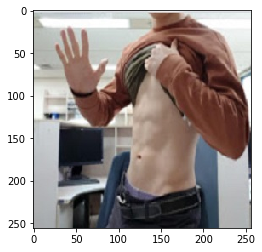

In [16]:
plt.imshow(sang)

In [46]:
sang=sang.transpose(2,1,0)

In [47]:
sang=torch.tensor(sang).unsqueeze(0)

In [19]:
sang.shape

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


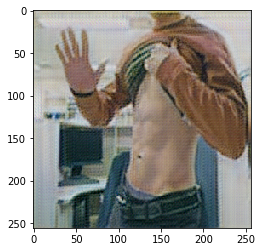

In [48]:
plt.imshow(g_BA(sang.float().to(device)).cpu().detach().numpy().transpose(0,3,2,1).squeeze(0))

In [91]:
g_AB(sang.float().to(device))

tensor([[[[0.8241, 0.8070, 0.5786,  ..., 0.4762, 0.4722, 0.4248],
          [0.6912, 0.7228, 0.7873,  ..., 0.4882, 0.4638, 0.3985],
          [0.7343, 0.7893, 0.8055,  ..., 0.3965, 0.5670, 0.4161],
          ...,
          [0.6600, 0.4878, 0.8476,  ..., 0.3973, 0.3863, 0.3837],
          [0.7751, 0.8230, 0.8942,  ..., 0.4119, 0.4580, 0.3952],
          [0.4756, 0.5725, 0.7521,  ..., 0.4651, 0.4738, 0.3998]],

         [[0.5382, 0.7234, 0.7164,  ..., 0.5159, 0.3975, 0.5252],
          [0.7142, 0.6428, 0.7215,  ..., 0.4859, 0.4569, 0.4675],
          [0.6390, 0.6883, 0.6688,  ..., 0.5451, 0.4055, 0.4348],
          ...,
          [0.8415, 0.7303, 0.6930,  ..., 0.4660, 0.4239, 0.3941],
          [0.7258, 0.6472, 0.6860,  ..., 0.4640, 0.4317, 0.4029],
          [0.8950, 0.6720, 0.5941,  ..., 0.4098, 0.4515, 0.3822]],

         [[0.6784, 0.6985, 0.5980,  ..., 0.4385, 0.4374, 0.4103],
          [0.4990, 0.6609, 0.6697,  ..., 0.4009, 0.3710, 0.3403],
          [0.6858, 0.7276, 0.5858,  ..., 0

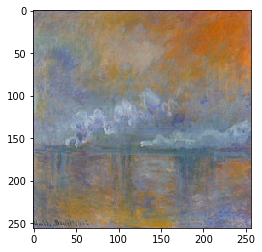

In [60]:
plt.imshow(testA.transpose(0,3,2,1)[11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


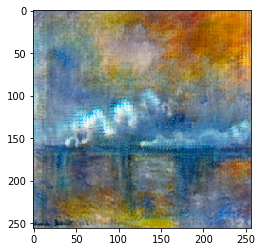

In [61]:
plt.imshow(g_AB(torch.tensor(testA[[11]]).float().to(device)).cpu().detach().numpy().transpose(0,3,2,1).squeeze(0))

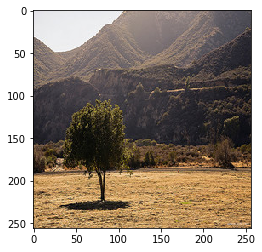

In [42]:
plt.imshow(testB.transpose(0,3,2,1)[222])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


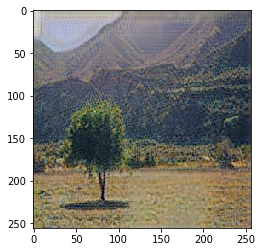

In [43]:
plt.imshow(g_BA(torch.tensor(testB[[222]]).float().to(device)).cpu().detach().numpy().transpose(0,3,2,1).squeeze(0))

In [21]:
sang= np.asarray(Image.open('./monet2photo/hojun.jpg'))
sang=sang/255

In [22]:
sang=sang.transpose(2,1,0)
sang=torch.tensor(sang).unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


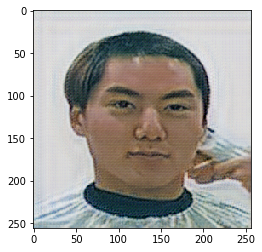

In [33]:
plt.imshow(g_BA(sang.float().to(device)).cpu().detach().numpy().transpose(0,3,2,1).squeeze(0))